# MNIST クラスタ分析



In [1]:
!pip install sklearn
!pip install numpy
!pip install seaborn
!pip install umap-learn
!pip install pyclustering

import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA  # PCA

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def get_pca(X, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(X)
    return pca.transform(X)

def load_mnist(path, kind='train'):

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

# visualization
def draw_image(data, row, col, n, title:str = None):
    ax = plt.subplot(row, col, n)
    ax.axis("off")
    if title is not None:
        ax.set_title(title, fontdict={'fontsize':8})
    plt.imshow(data, cmap = "gray")

def draw_text(text, row, col, n):
    ax = plt.subplot(row, col, n)
    ax.axis("off")

    # build a rectangle in axes coords
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    ax.text(0.5*(left+right), 0.5*(bottom+top), text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=12, color='black',
        transform=ax.transAxes)

def plot_image(X_image, indexes, row=1, col=10, image_size=28, title:str = None, figsize=(10, 2)):
    fig = plt.figure(figsize=figsize)
    if title is not None:
#         plt.gcf().text(0.0, 0.0, title)
#         fig.suptitle(title)
        fig.suptitle(title, fontsize=20, y=0.91)
        plt.subplots_adjust(wspace=0.2, hspace=0.25)
    offset = 0
    for index in indexes:
        offset += 1
        draw_image(X_image[index].reshape(image_size,image_size), row, col, offset, index)
    plt.show()

def plot_hist_image(X_image, indexes, row=1, col=10):
    """ヒストグラム作成
    """
    
    fig = plt.figure(figsize=(10, 1))
    offset = 0
    for index in indexes:
        offset += 1

        # ヒストグラムの取得
        img_hist, _ = np.histogram(np.array(X_image[index]).flatten(), bins=np.arange(256+1))

        # ヒストグラムの表示
        ax = plt.subplot(row, col, offset)
        ax.axis("off")
        plt.plot(img_hist, color='black', linewidth = 1)
    plt.show()

    
def plot_image_and_hist(X_image, indexes, prefix, n_class, row=20, col=10):
   
    fig = plt.figure(figsize=(10, 20))
    fig.suptitle(f'{prefix} Analyze Class:{n_class}', fontsize=20, y=0.925)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

    offset = 0
    for index in indexes:
        offset += 1

        # 画像表示
        draw_image(X_image[index].reshape(28,28), row, col, offset, str(index))

        # ヒストグラムの取得
        img_hist, _ = np.histogram(np.array(X_image[index]).flatten(), bins=np.arange(256+1))
        # ヒストグラムの表示
        ax = plt.subplot(row, col, offset+col)
        ax.axis("off")
        plt.plot(img_hist, color='black', linewidth = 1)

        if offset % col == 0:
            # ヒストグラム行を飛ばす
            offset += col

    plt.show()


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
# 画像クラスタリング x-mean
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython.display import display, HTML # Jupyter notebook用
%matplotlib inline

class XMeans:
    """
    x-means法を行うクラス
    """

    def __init__(self, k_init = 2, **k_means_args):
        """
        k_init : The initial number of clusters applied to KMeans()
        """
        self.k_init = k_init
        self.k_means_args = k_means_args

    def fit(self, X):
        """
        x-means法を使ってデータXをクラスタリングする
        X : array-like or sparse matrix, shape=(n_samples, n_features)
        """
        self.__clusters = [] 

        clusters = self.Cluster.build(X, KMeans(self.k_init, **self.k_means_args).fit(X))
        self.__recursively_split(clusters)

        self.labels_ = np.empty(X.shape[0], dtype = np.intp)
        for i, c in enumerate(self.__clusters):
            self.labels_[c.index] = i

        self.cluster_centers_ = np.array([c.center for c in self.__clusters])
        self.cluster_log_likelihoods_ = np.array([c.log_likelihood() for c in self.__clusters])
        self.cluster_sizes_ = np.array([c.size for c in self.__clusters])

        return self

    def __recursively_split(self, clusters):
        """
        引数のclustersを再帰的に分割する
        clusters : list-like object, which contains instances of 'XMeans.Cluster'
        'XMeans.Cluster'のインスタンスを含むリスト型オブジェクト
        """
        for cluster in clusters:
            if cluster.size <= 3:
                self.__clusters.append(cluster)
                continue

            k_means = KMeans(2, **self.k_means_args).fit(cluster.data)
            c1, c2 = self.Cluster.build(cluster.data, k_means, cluster.index)

            if np.linalg.det(c1.cov) == 0 and np.linalg.det(c2.cov) == 0:
                  beta = 0
            else:
                  beta = np.linalg.norm(c1.center - c2.center) / np.sqrt(np.linalg.det(c1.cov) + np.linalg.det(c2.cov))
            
            alpha = 0.5 / stats.norm.cdf(beta)
            bic = -2 * (cluster.size * np.log(alpha) + c1.log_likelihood() + c2.log_likelihood()) + 2 * cluster.df * np.log(cluster.size)

            if bic < cluster.bic():
                self.__recursively_split([c1, c2])
            else:
                self.__clusters.append(cluster)

    class Cluster:
        """
        k-means法によって生成されたクラスタに関する情報を持ち、尤度やBICの計算を行うクラス
        """

        @classmethod
        def build(cls, X, k_means, index = None): 
            if index is None:
                index = np.array(range(0, X.shape[0]))
            labels = range(0, k_means.get_params()["n_clusters"])  

            return tuple(cls(X, index, k_means, label) for label in labels) 

        # index: Xの各行におけるサンプルが元データの何行目のものかを示すベクトル
        def __init__(self, X, index, k_means, label):
            self.data = X[k_means.labels_ == label]
            self.index = index[k_means.labels_ == label]
            self.size = self.data.shape[0]
            self.df = self.data.shape[1] * (self.data.shape[1] + 3) / 2
            self.center = k_means.cluster_centers_[label]
            self.cov = np.cov(self.data.T)

        def log_likelihood(self):
            return sum(stats.multivariate_normal.logpdf(x, self.center, self.cov) for x in self.data)

        def bic(self):
            return -2 * self.log_likelihood() + self.df * np.log(self.size)

In [3]:
# load data

X_target, y_target = load_mnist('../data/Fashion-MNIST', kind='train')

# 前処理として、画像を最大値255で割って0.0 - 1.0に規格化する。
X_target_n = X_target / 255

print(type(X_target))
print(X_target.shape)

<class 'numpy.ndarray'>
(60000, 784)


In [4]:
classes = np.unique(y_target)
target_indexes={}

# クラス分類
for c in classes:
    target_indexes[c] = np.where(y_target == c)[0]

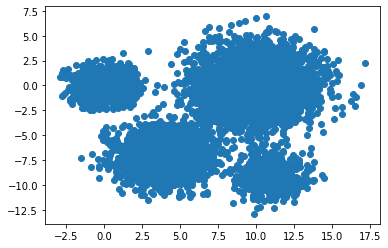

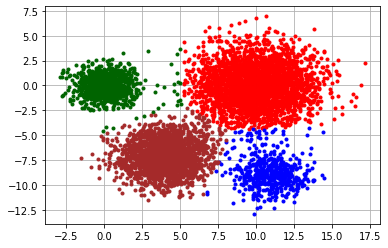

<AxesSubplot:>

In [5]:
# 2次元のx-means例

import pyclustering
from pyclustering.cluster import xmeans
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

arr_1 = np.random.normal(scale=1.0, size=(1000, 2))
arr_2 = np.random.normal(scale=2.0, size=(3000, 2))
arr_3 = np.random.normal(scale=1.5, size=(2000, 2))
arr_4 = np.random.normal(scale=1.2, size=(500, 2))
arr_2[:, 0] += 10
arr_3[:, 0] += 4
arr_3[:, 1] += -7
arr_4[:, 0] += 11
arr_4[:, 1] += -9
X = np.concatenate([
    arr_1,
    arr_2,
    arr_3,
    arr_4,
])

plt.scatter(x=X[:, 0], y=X[:, 1])

initializer = xmeans.kmeans_plusplus_initializer(data=X, amount_centers=2)
initial_centers = initializer.initialize()
xm = xmeans.xmeans(data=X, initial_centers=initial_centers)
xm.process()
clusters = xm.get_clusters()
pyclustering.utils.draw_clusters(data=X, clusters=clusters)

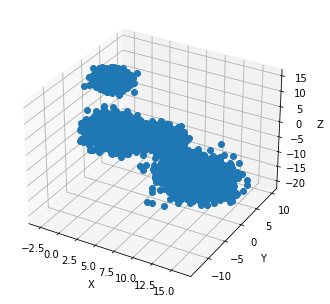

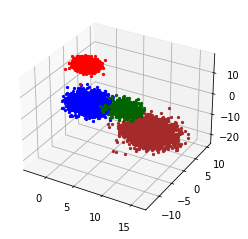

In [6]:
# 3次元のx-means例

arr_1 = np.random.normal(scale=1.0, size=(1000, 3))
arr_2 = np.random.normal(scale=2.0, size=(3000, 3))
arr_3 = np.random.normal(scale=1.5, size=(2000, 3))
arr_4 = np.random.normal(scale=1.2, size=(500, 3))
arr_1[:, 2] += 13
arr_2[:, 0] += 10
arr_2[:, 1] += 3
arr_2[:, 2] += -15
arr_3[:, 0] += 4
arr_3[:, 1] += -7
arr_3[:, 2] += 5
arr_4[:, 0] += 11
arr_4[:, 1] += -9
arr_4[:, 2] += 10
X = np.concatenate([
    arr_1,
    arr_2,
    arr_3,
    arr_4,
])

#3次元プロットするためのモジュール
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.plot(X[:, 0],X[:, 1],X[:, 2],marker="o",linestyle='None')
plt.show()


initializer = xmeans.kmeans_plusplus_initializer(data=X, amount_centers=2)
initial_centers = initializer.initialize()
xm = xmeans.xmeans(data=X, initial_centers=initial_centers)
xm.process()
clusters = xm.get_clusters()
ax = pyclustering.utils.draw_clusters(data=X, clusters=clusters)

In [10]:
from sklearn.decomposition import KernelPCA
import pandas as pd

def calc_xmean(c, n_components):
    gamma = 0.01
    pca = KernelPCA(n_components=n_components, kernel="rbf" ,gamma=gamma)
    X = pca.fit_transform(X_target_n[target_indexes[c]])
#     X = get_pca(X_target_n[target_indexes[c]], n_components)
#     X = X_target_n[target_indexes[c]]
    initializer = xmeans.kmeans_plusplus_initializer(data=X, amount_centers=2)
    initial_centers = initializer.initialize()
    xm = xmeans.xmeans(data=X, initial_centers=initial_centers, kmax=128)
    xm.process()

    clusters = xm.get_clusters()
    centers = xm.get_centers()
    print('Class:{} cluster num={}'.format(c, len(clusters)))
    
    # クラスタ間の情報分析
    
    # クラスタ単位の情報分析
    cls_no = 0
    for cls_index, cls_center in zip(clusters, centers):

        # 中心点と各画像の最長距離、平均距離を算出
        max_distance = 0
        max_distance_i = 0
        sum_distance = 0
        distancies = []
        for i in cls_index:
            distance = np.linalg.norm(cls_center - X[i])
            sum_distance += distance
            if max_distance < distance:
                max_distance = distance
                max_distance_i = i

        print('Class:{} / Cluster:{} image num={} mean_distance={} max_distance={}'.format(
            c, cls_no, len(cls_index), sum_distance/len(cls_index), max_distance))

#         row_num = (len(cls_index)/10)+1
#         plot_image(X_target, target_indexes[c][cls_index], row=row_num, col=10, title=f'{cls_no}', figsize=(10, 1.2*row_num))

        pca = KernelPCA(n_components= 2, kernel="rbf" ,gamma=c)
        X = pca.fit_transform(X_target_n[target_indexes[c]])

        pca_pd = pd.DataFrame(X)
        pca_pd["class"]= clusters
        pca_pd.columns = ["x0","x1", "class"]
        plt.title("Kernel PCA")
        sns.scatterplot(x="x0", y= "x1", hue="class", data=pca_pd, )

        cls_no+=1
        
calc_xmean(c=0, n_components=32)

# for c in classes:
#     calc_xmean(c)

Class:0 cluster num=56
Class:0 / Cluster:0 image num=159 mean_distance=0.2016054611405712 max_distance=0.3949514213023312


ValueError: Length of values (56) does not match length of index (6000)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
import seaborn as sns
Gam =[0.01, 0.1, 1]
plt.figure(figsize=(14,3))
for i,c in enumerate(Gam):
    plt.subplot(1,3, i+1)
    pca = KernelPCA(n_components= 2, kernel="rbf" ,gamma=c)
    iris_pca = pca.fit_transform(X_target_n)
    
    iris_pca_pd = pd.DataFrame(iris_pca)
    iris_pca_pd["class"]= y_target
    iris_pca_pd.columns = ["x0","x1", "class"]
    sns.scatterplot(x="x0", y= "x1", hue="class", data=iris_pca_pd, )
    plt.title("Kernel PCA gamma={}".format(c) )

In [ ]:
pca = KernelPCA(n_components= 2, kernel="rbf" ,gamma=0.01)
iris_pca = pca.fit_transform(X_target_n[target_indexes[0]])

iris_pca_pd = pd.DataFrame(iris_pca)
iris_pca_pd

In [ ]:
#install these if you haven’t
!pip install chart_studio 
!pip install plotly
import plotly as py
import plotly.graph_objs as go
import plotly.express as px
#3D Plotly Visualization of Clusters using go
layout = go.Layout(
    title='<b>Cluster Visualisation</b>',
    yaxis=dict(
        title='<i>Y</i>'
    ),
    xaxis=dict(
        title='<i>X</i>'
    )
)
colors = ['red','green' ,'blue','purple','magenta','yellow','cyan','maroon','teal','black']
trace = [ go.Scatter3d() for _ in range(11)]
for i in range(0,10):
    my_members = (clusters == i)
    index = [h for h, g in enumerate(my_members) if g]
    trace[i] = go.Scatter3d(
            x=Clus_dataSet[my_members, 0],# 0 is a component among the 420 components. Feel free to change it
            y=Clus_dataSet[my_members, 1],# 1 is a component among the 420 components. Feel free to change it
            z=Clus_dataSet[my_members, 2],# 2 is a component among the 420 components. Feel free to change it
            mode='markers',
            marker = dict(size = 2,color = colors[i]),
            hovertext=index,
            name='Cluster'+str(i),
   
            )
fig = go.Figure(data=[trace[0],trace[1],trace[2],trace[3],trace[4],trace[5],trace[6],trace[7],trace[8],trace[9]], layout=layout)
    
py.offline.iplot(fig)

In [ ]:
from sklearn.datasets import make_blobs
import pandas as pd

X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=5,
                  cluster_std=0.8,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility


x =X[:,0]
y =X[:,1]
X=np.c_[x,y]



import seaborn as sns
sns.jointplot('X', 'Y', data=pd.DataFrame(X, columns=['X', 'Y']))
# sns.pairplot(pd.DataFrame(X))
#     sns.countplot(x='label', data=pd.DataFrame(labels, columns=['label']))X)

# plt.scatter(X[:,0],X[:,1],c='white',marker='o',s=50)
# plt.grid()
# plt.show()

In [ ]:
import matplotlib.pyplot as plt

# データの準備
# x = np.array([np.random.normal(loc, 0.1, 20) for loc in np.repeat([1,2], 2)]).flatten() #ランダムな80個の数を生成
# y = np.array([np.random.normal(loc, 0.1, 20) for loc in np.tile([1,2], 2)]).flatten() #ランダムな80個の数を生成


# クラスタリングの実行
x_means = XMeans(random_state = 1).fit(np.c_[x,y])  
print(x_means.labels_)
print(x_means.cluster_centers_)
print(x_means.cluster_log_likelihoods_)
print(x_means.cluster_sizes_)


df = pd.DataFrame(np.insert(X, 2, x_means.labels_, axis=1), columns=['X', 'Y', 'Class'])

# 結果をプロット
# sns.scatterplot(data=df, 
#                 x='X', 
#                 y='Y',
#                 hue='Class')

plt.scatter(x, y, c = x_means.labels_, s = 30)
plt.scatter(x_means.cluster_centers_[:,0], x_means.cluster_centers_[:,1], c = "r", marker = "+", s = 100)
# plt.xlim(0, 3)
# plt.ylim(0, 3)
# plt.title("x-means_test1")
# plt.legend()
# plt.grid()
plt.show()

In [ ]:
# # 画像クラスタリング BayesianGaussianMixture
# import time
# import numpy as np
# import pandas as pd
# from sklearn import mixture

# # 次元圧縮数
# pca_n_components = 128
# max_bgm_n_components = 64
# max_iter = 5000

# def classification(c):
#     # class,label,count,percent
#     cls_data = np.zeros((0, 4))

#     # class,label,index
#     index_data = np.zeros((0, 3), dtype=np.int64)

#     print(f'Class({c}) start')
    
#     t1 = time.time() 

#     # 次元圧縮
#     X = get_pca(X_target_n[target_indexes[c]], pca_n_components)

#     # クラスタリング(クラスタ数取得)
#     vbgm = mixture.BayesianGaussianMixture(n_components=max_bgm_n_components, max_iter=max_iter).fit(X)
#     vbgm.predict(X)

#     # クラスタ数算出
#     bgm_n_components = len(np.where(vbgm.weights_>vbgm.weights_.mean())[0])
#     print(f'change bgm_n_components {max_bgm_n_components} ===> {bgm_n_components}')
    
#     # クラスタリング
#     vbgm = mixture.BayesianGaussianMixture(n_components=bgm_n_components, max_iter=max_iter).fit(X)
#     labels = vbgm.predict(X)

#     print('Class({}) label_num={}'.format(c, np.unique(labels)))

#     t2 = time.time()
#     print(f"経過時間：{t2-t1}")

#     # ヒストグラム出力
#     sns.countplot(x='label', data=pd.DataFrame(labels, columns=['label']))
    
#     label_classes = np.unique(labels)
#     for l in label_classes:
#         indexes = np.where(labels == l)[0]
#         total_indexes = [target_indexes[c][i] for i in indexes]
#         cnt=len(indexes)
#         persent=(cnt*100.0)/len(labels)
#         print('class:{}/label:{} = {} ({}%)'.format(c, l, cnt, persent))
        
#         # 出力df作成
#         cls_data = np.vstack((cls_data, [c, l, cnt, persent]))
#         for i in total_indexes:
#             index_data = np.vstack((index_data, [c, l, i]))

#         # 画像出力
#         plot_image(X_target, total_indexes[0:10], title=f'Class:{c} / Label:{l} count={cnt}')
        
#     # 分類概要情報をCSV出力
#     cls_df = pd.DataFrame(cls_data,
#                           columns=['class', 'label', 'count', 'persent'])
#     cls_df['class'] = cls_df['class'].astype(np.int64)
#     cls_df['label'] = cls_df['label'].astype(np.int64)
#     cls_df['count'] = cls_df['count'].astype(np.int64)
#     cls_df.to_csv(f'class_{c}_cls.csv', header=True, index=True)
    
#     # 分類されたインデックスをＣＳＶ出力
#     index_df = pd.DataFrame(index_data,
#                           columns=['class', 'label', 'index'])
#     index_df.to_csv(f'class_{c}_index.csv', header=True, index=True)

# for c in classes:
#     classification(c)